# **Car Evaluation Analysis**

### DSCI 310 2024W Group 5

#### Authors:
- Nika Karimi Seffat
- Ethan Wang
- Gautam Arora
- Kevin Li

### **Introduction**

**Background**: 

Cars and personal transportation are an inevitable part of everyday life in the developed world. They play a crucial role in people's daily routines, enabling them to commute to work, travel, attend social gatherings, and explore new places. However, cars also pose significant safety risks. In 2023 alone, car accidents accounted for over 40,000 fatalities (Wikipedia Contributors, 2019). Given these risks, it is no surprise that many individuals seek ways to make car travel safer while maintaining its convenience and necessity.

Research has shown that consumers are willing to invest in vehicle safety. For example, Andersson (2008) found that Swedish drivers were willing to pay a premium for improved car design and build quality to reduce the risk of injury in accidents. Additionally, design and material choices play a critical role in determining a vehicle's safety. Nygren (1983) found that factors such as a car’s weight, seatbelt design, and headrests significantly influenced accident survivability. More recently, Richter et al. (2005) demonstrated that passive safety improvements—such as enhanced structural integrity and interior design modifications—have contributed to a measurable decline in injury rates from car accidents. These findings highlight the importance of identifying key factors that contribute to vehicle safety.

Given this context, our research project aims to answer the following question:

**Can we predict the estimated safety of a car using various attributes, such as its buying price, capacity (persons), and maintenance cost?**

To answer this question, we will use the Car Evaluation Dataset from UC Irvine’s Machine Learning Repository. This multivariate classification dataset contains six car design and classification variables, and includes 1,728 observations. Key variables that will be central to our analysis include the car’s buying price, maintenance cost, seating capacity (in terms of the number of passengers it can accommodate), and the car’s evaluation level (categorized as unacceptable, acceptable, good, or very good).

## **Methods and Results**

### **Data Loading**

The dataset was retrieved from an online source and loaded into R for analysis using the read.csv function. This dataset contains categorical variables describing various attributes of cars, which will be used for classification.

In [3]:
# First, we will load the required libraries necessary to perform data wrangling, visualization, and analysis.
library(ggplot2) # Contains dplyr, ggplot2, and other libraries to perform data cleaning and visualization.
library(dplyr)
library(class) # For the kNN Classifier.
library(caret) # For train-test-split and cross-validation.

In [4]:
# Loading the dataset from the web
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data"
car_data <- read.csv(url, header = FALSE, stringsAsFactors = TRUE) # since all input variables are categorical, we set the data type to a factor.

# Display first few rows
head(car_data)

,V1,V2,V3,V4,V5,V6,V7
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
1,vhigh,vhigh,2,2,small,low,unacc
2,vhigh,vhigh,2,2,small,med,unacc
3,vhigh,vhigh,2,2,small,high,unacc
4,vhigh,vhigh,2,2,med,low,unacc
5,vhigh,vhigh,2,2,med,med,unacc
6,vhigh,vhigh,2,2,med,high,unacc


Although the dataset comes with predefined columns, it does not include column names when we read in the CSV file. We manually assign meaningful column names based on the UCI dataset documentation.

In [5]:
# Assigning the column names
colnames(car_data) <- c("buying", "maint", "doors", "persons", "lug_boot", "safety", "class")
head(car_data)

,buying,maint,doors,persons,lug_boot,safety,class
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
1,vhigh,vhigh,2,2,small,low,unacc
2,vhigh,vhigh,2,2,small,med,unacc
3,vhigh,vhigh,2,2,small,high,unacc
4,vhigh,vhigh,2,2,med,low,unacc
5,vhigh,vhigh,2,2,med,med,unacc
6,vhigh,vhigh,2,2,med,high,unacc


#### **Data Wrangling and Cleaning**

In [6]:
# Checking for missing values:
sum(is.na(car_data))

[1] 0

Amazing! No missing values to drop or account for.

In [7]:
# Check for duplicate values:
# Remove duplicate rows (if any)
car_data <- car_data %>% distinct()
nrow(car_data)

[1] 1728

We have the same number of rows as before - there were no duplicate rows!

#### Data Types

Since k-Nearest Neighbors (kNN) is a distance-based algorithm, it requires numerical input for feature comparisons. However, our dataset currently consists of categorical variables (all factors in R).

In [8]:
# Every variable in this dataset is an ordinal variable - it falls under the categorical variables that have a natural relationship or hierarchy to them.
# We can use ordinal encoding to transform these factor variables into double so kNN can be used on them. Scaling is NOT needed here.

# Define encoding function for all categorical features (
encode_levels <- function(x) {
  case_when(
    x == "vhigh"  ~ 4,   
    x == "high"   ~ 3,
    x == "med"    ~ 2, 
    x == "low"    ~ 1,
    x == "big"    ~ 3,
    x == "small"  ~ 1,
    x == "more"   ~ 5,   # 'more' in persons column treated as 5
    x == "5more"  ~ 5,   # '5more' in doors column treated as 5
    x == "2"      ~ 2,
    x == "3"      ~ 3,
    x == "4"      ~ 4,
    x == "unacc"  ~ 1,
    x == "acc"    ~ 2,
    x == "good"   ~ 3,
    x == "vgood"  ~ 4,
    TRUE          ~ as.numeric(x) # Default conversion for numbers
  )
}

# Encoding safety separately to avoid duplicate "low", "med", "high"
encode_safety <- function(x) {
  case_when(
    x == "low"  ~ 1,
    x == "med"  ~ 2,
    x == "high" ~ 3,
    TRUE        ~ as.numeric(x)
  )
}

# Apply encoding to all columns, including safety separately
car_data_encoded <- car_data %>%
  mutate(across(-safety, encode_levels)) %>%
  mutate(safety = encode_safety(safety))  # Encode safety

# Display first few rows
head(car_data_encoded)

,buying,maint,doors,persons,lug_boot,safety,class
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,4,4,2,2,1,1,1
2,4,4,2,2,1,2,1
3,4,4,2,2,1,3,1
4,4,4,2,2,2,1,1
5,4,4,2,2,2,2,1
6,4,4,2,2,2,3,1


**Since we converted the text into numerical variables, we have attached the description of each numerical value per feature below for reference:**

**`buying` and `maint`**
- low: 1
- med: 2
- high: 3
- vhigh: 4

**`doors` and `persons`**
- The values are technically numerical, but they only fall into 3 or 4 categories and are not continuous.

**`lug_boot` and `safety`**
- small/low: 1
- med: 2
- big/high: 3

**`class`**
- unacc (unacceptable): 1
- acc (acceptable): 2
- good: 3
- vgood: 4

**The data has been cleaned and is ready for analysis!**

#### **Summary of Data**

In [9]:
summary(car_data_encoded)

     buying         maint          doors         persons         lug_boot
 Min.   :1.00   Min.   :1.00   Min.   :2.00   Min.   :2.000   Min.   :1  
 1st Qu.:1.75   1st Qu.:1.75   1st Qu.:2.75   1st Qu.:2.000   1st Qu.:1  
 Median :2.50   Median :2.50   Median :3.50   Median :4.000   Median :2  
 Mean   :2.50   Mean   :2.50   Mean   :3.50   Mean   :3.667   Mean   :2  
 3rd Qu.:3.25   3rd Qu.:3.25   3rd Qu.:4.25   3rd Qu.:5.000   3rd Qu.:3  
 Max.   :4.00   Max.   :4.00   Max.   :5.00   Max.   :5.000   Max.   :3  
     safety      class      
 Min.   :1   Min.   :1.000  
 1st Qu.:1   1st Qu.:1.000  
 Median :2   Median :1.000  
 Mean   :2   Mean   :1.415  
 3rd Qu.:3   3rd Qu.:2.000  
 Max.   :3   Max.   :4.000  

In [10]:
# Count occurrences for each unique value in each column
car_data_encoded %>%
  pivot_longer(cols = everything(), names_to = "Variable", values_to = "Value") %>%
  group_by(Variable, Value) %>%
  summarise(Count = n(), .groups = "drop") %>%
  arrange(Variable, desc(Count))

Variable,Value,Count
<chr>,<dbl>,<int>
buying,1,432
buying,2,432
buying,3,432
buying,4,432
class,1,1210
class,2,384
class,3,69
class,4,65
doors,2,432


This frequency table provides a clearer picture of the dataset's distribution across categorical variables. The `buying`, `maint`, and `doors` features all have an even distribution, with each level appearing 432 times, suggesting a balanced dataset for these features. The `safety`, `lug_boot` and `persons` features are also evenly distributed across its three levels, with 576 occurrences each, ensuring no significant class imbalance in this variable. However, the `class` is highly imbalanced, with "unacc" (encoded as 1) making up the majority (1,210 occurrences), while "vgood" (encoded as 4) is rare (only 65 occurrences). Since we are not using the `class` variable in our analysis, this is not much of a concern.

**Our x and y variables all have sufficient data points for analysis!**

#### **EDA Analysis - Visualization**

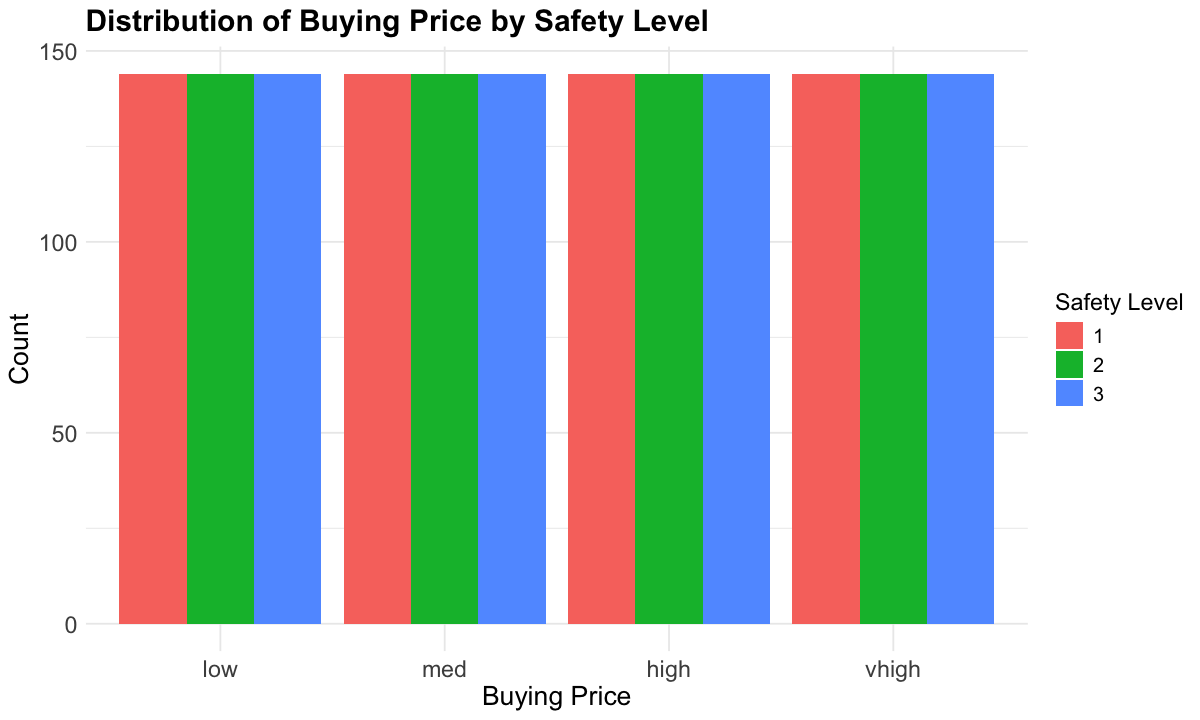

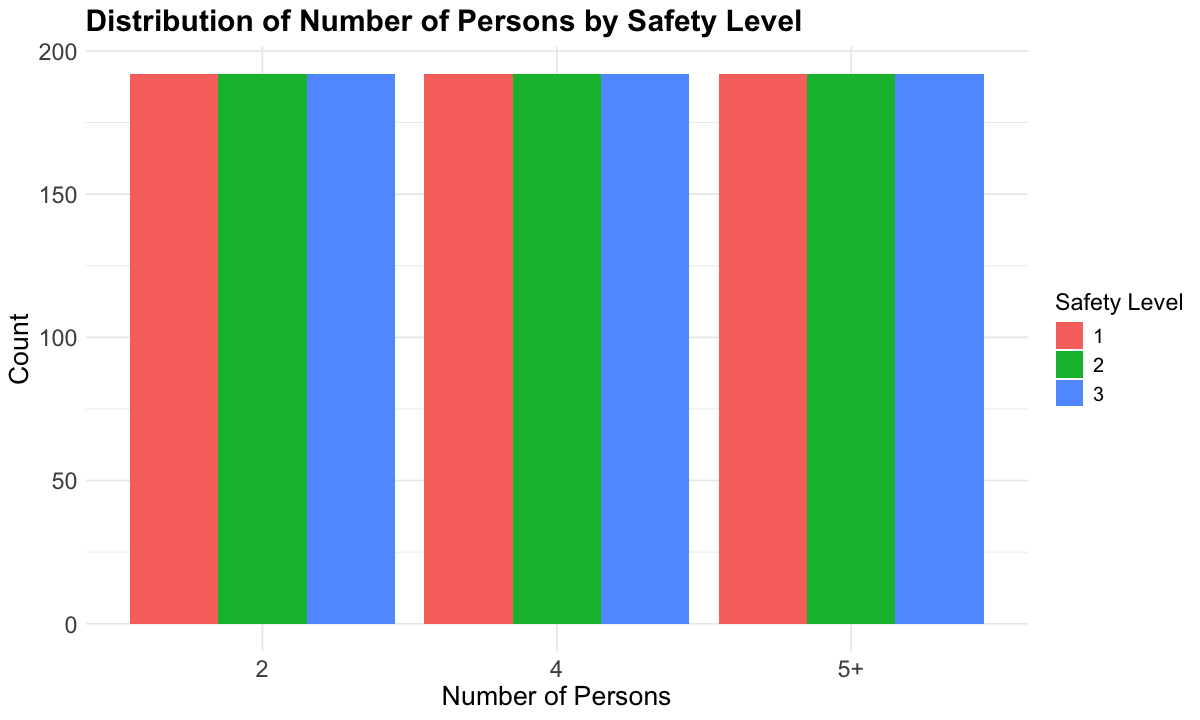

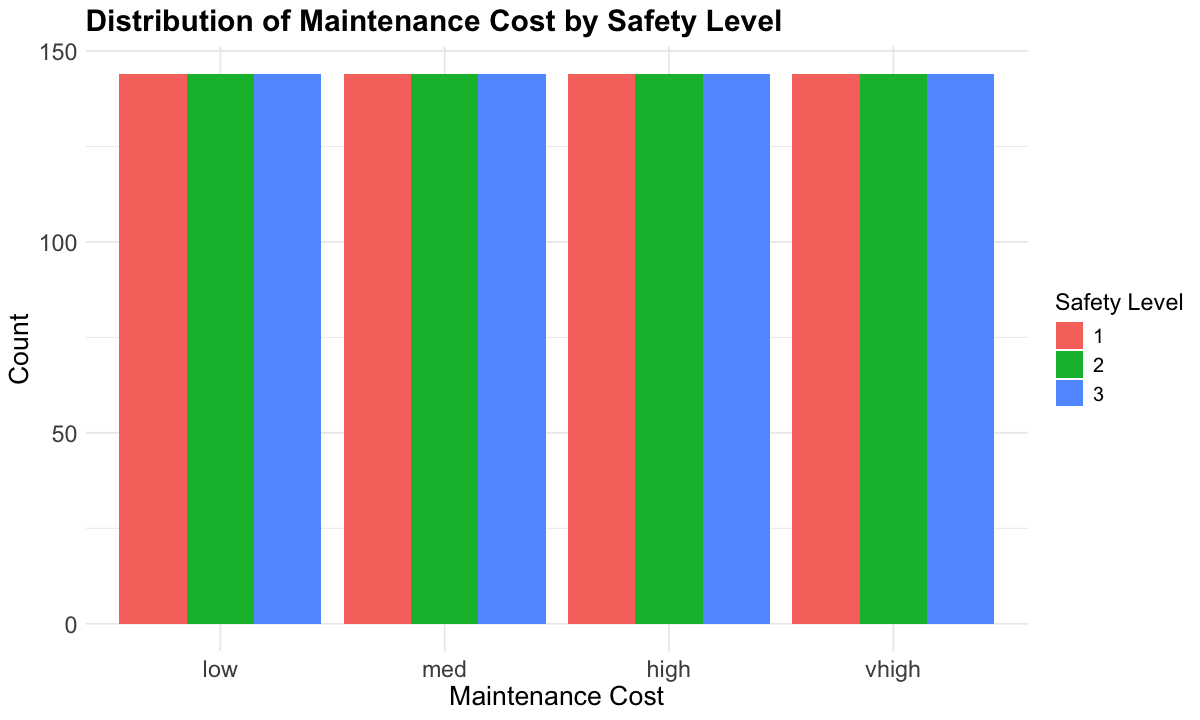

In [11]:
# Convert encoded variables back to their categorical labels
# Bar plot of safety distribution

car_data_labeled <- car_data_encoded %>%
  mutate(
    buying = factor(buying, levels = c(1, 2, 3, 4), labels = c("low", "med", "high", "vhigh")),
    maint = factor(maint, levels = c(1, 2, 3, 4), labels = c("low", "med", "high", "vhigh")),
    persons = factor(persons, levels = c(2, 4, 5), labels = c("2", "4", "5+")), 
    class = factor(class, levels = c(1, 2, 3, 4), labels = c("unacc", "acc", "good", "vgood")),
    safety = as.factor(safety)  # Keep safety as a factor for color coding
  )

# Define a larger theme for all plots
larger_theme <- theme(
  plot.title = element_text(size = 18, face = "bold"), # Larger title
  axis.title = element_text(size = 16),  # Larger axis labels
  axis.text = element_text(size = 14),  # Larger axis values
  legend.title = element_text(size = 14),  # Larger legend title
  legend.text = element_text(size = 12)  # Larger legend values
)

# Increase figure size, default size is not very readable
options(repr.plot.width = 10, repr.plot.height = 6)

# Plot 1: Distribution of Buying Price by Safety Level
ggplot(car_data_labeled, aes(x = buying, fill = safety)) +
  geom_bar(position = "dodge") +
  labs(title = "Distribution of Buying Price by Safety Level",
       x = "Buying Price", y = "Count", fill = "Safety Level") +
  theme_minimal() + larger_theme

# Plot 2: Distribution of Number of Persons by Safety Level
ggplot(car_data_labeled, aes(x = persons, fill = safety)) +
  geom_bar(position = "dodge") +
  labs(title = "Distribution of Number of Persons by Safety Level",
       x = "Number of Persons", y = "Count", fill = "Safety Level") +
  theme_minimal() + larger_theme

# Plot 3: Distribution of Maintenance Cost by Safety Level
ggplot(car_data_labeled, aes(x = maint, fill = safety)) +
  geom_bar(position = "dodge") +
  labs(title = "Distribution of Maintenance Cost by Safety Level",
       x = "Maintenance Cost", y = "Count", fill = "Safety Level") +
  theme_minimal() + larger_theme


**Figure 1: Histograms of Safety Across 3 Input Variables: Buying Price, Capacity (Number of Persons), and Maintenance Cost**

As we saw in the summary table, all the safety levels are evenly distributed across each of the independent variables.

**Initial Observations**

The histograms indicate that the safety levels (1, 2, and 3) are evenly distributed across all three independent variables: buying price, number of persons, and maintenance cost. This suggests that the dataset is well-balanced with respect to safety levels, meaning that safety is not disproportionately concentrated in any particular category of these features. However, we do not observe significant variation is observed in the distribution of safety across these variables.


**Proceeding with Analysis**

While individual variables may not show a strong distinction in safety levels on their own, the interaction between multiple features could still be meaningful for classification. Just because safety is evenly distributed across each independent variable separately doesn't mean that a combination of factors (e.g., high buying price + low maintenance + more persons) won't reveal patterns that help predict safety levels.

#### **kNN Classification Analysis**

In [34]:
set.seed(123)  # We put this to ensure reproducibility in our data, since splitting into training and test splits will be random.

# Convert categorical variables to factors
car_data_prepared <- car_data_encoded %>%
  mutate(safety = as.factor(safety))  # The target variable must be a factor for classification models in R

# Split the dataset into training (80%) and testing (20%) sets
# This ensures that the model is trained on one portion of the data and tested on unseen data for evaluation
train_index <- createDataPartition(car_data_prepared$safety, p = 0.8, list = FALSE)  # Randomly select 80% of data for training
train_data <- car_data_prepared[train_index, ]  # Training data
test_data <- car_data_prepared[-train_index, ]  # Testing data

# Separate features and target variable
train_x <- train_data %>% select(-safety)  # Predictor variables
train_y <- train_data$safety               # Target variable
test_x <- test_data %>% select(-safety)
test_y <- test_data$safety

In [35]:
# Define k values to test (odd values to prevent ties)
k_values <- seq(1, 21, 2)

# Store cross-validation results
cv_results <- data.frame(k = integer(), accuracy = numeric())  

# Perform cross-validation for each k value
for (k in k_values) {
  set.seed(123)  # Ensure reproducibility in CV

  knn_model <- train(
    train_x, train_y, method = "knn",
    trControl = trainControl(method = "cv", number = 5),  # 5-fold CV
    tuneGrid = data.frame(k = k)
  )

  # Store cross-validation accuracy
  cv_results <- rbind(cv_results, data.frame(k = k, accuracy = max(knn_model$results$Accuracy)))
}

# Best k based on cross-validation accuracy
best_k <- cv_results$k[which.max(cv_results$accuracy)]
best_cv_accuracy <- max(cv_results$accuracy)  # Best cross-validation accuracy

cat("Best k found through cross-validation:", best_k, "\n")
cat("Best cross-validation accuracy:", round(best_cv_accuracy * 100, 2), "%\n")

Best k found through cross-validation: 17 
Best cross-validation accuracy: 47.22 %


In [36]:
# Train the final model with the best k
final_knn_model <- train(
  train_x, train_y, method = "knn",
  trControl = trainControl(method = "none"),  # No CV, just final training
  tuneGrid = data.frame(k = best_k)
)

# Generate predictions on the test set
predictions <- predict(final_knn_model, test_x)

# Compute test accuracy
test_accuracy <- sum(predictions == test_y) / length(test_y)

cat("Test Set Accuracy:", round(test_accuracy * 100, 2), "%\n")

Test Set Accuracy: 46.09 %


The final kNN model achieved 46.09% accuracy, which is somewhat reflective of the CV accuracy of 47.22%. This is not a great accuracy, but it's better than random guessing, which would be ~33.33%.

#### **Visualization of Analysis**

Since we are using multiple input variables for our kNN classification, it wouldn't be possible to graph it out 2D. We will do a **confusion matrix** as our visualization.

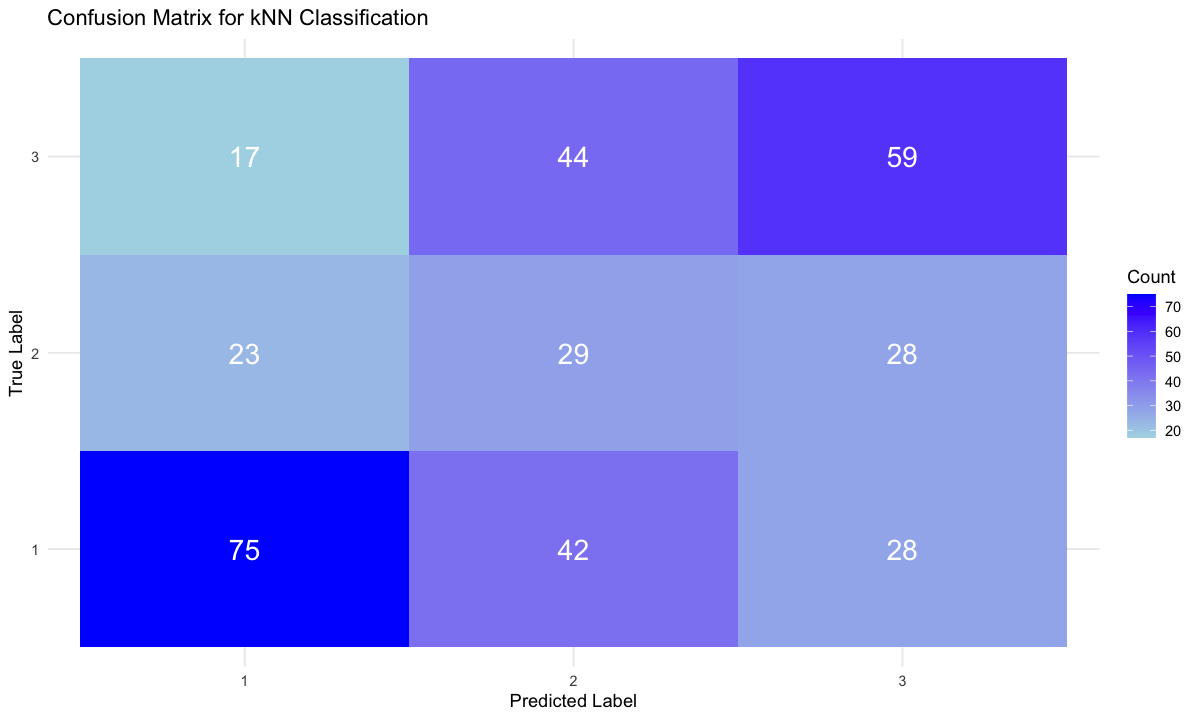

In [33]:
# Generate the confusion matrix to evaluate model performance
# This compares the predicted labels (final_knn) with the actual test labels (test_y)
conf_matrix <- confusionMatrix(final_knn, test_y)

# Convert confusion matrix into a tidy format for plotting
# The confusionMatrix function stores results in a table format, so we extract and reformat it
conf_matrix_df <- as.data.frame(conf_matrix$table)

# Rename columns for clarity (matching true and predicted values)
colnames(conf_matrix_df) <- c("True_Label", "Predicted_Label", "Count")

# Plot a heatmap to visualize classification performance
ggplot(conf_matrix_df, aes(x = Predicted_Label, y = True_Label, fill = Count)) +
  geom_tile() +  # Creates a grid-based heatmap
  geom_text(aes(label = Count), color = "white", size = 6) +  # Add count values to each cell
  scale_fill_gradient(low = "lightblue", high = "blue") +  # Use a color gradient for better visualization
  labs(title = "Confusion Matrix for kNN Classification",
       x = "Predicted Label", y = "True Label", fill = "Count") +  # Customize labels
  theme_minimal()  # Apply a clean, minimal theme

**Figure 2: Heatmap of Confusion Matrix for Visualization of Analysis**

## Discussion

### What We Found
The analysis started with a car evaluation dataset lacking column names, which were manually assigned as "buying," "maint," "doors," "persons," "lug_boot," "safety," and "class" based on UCI documentation. The dataset, comprising 1,728 rows, was clean with no missing values or duplicates. All variables were categorical and ordinal, necessitating ordinal encoding into numerical values for k-Nearest Neighbors (kNN) analysis. Summary statistics revealed balanced distributions across most features (e.g., "buying," "maint," "doors," "lug_boot," "safety," and "persons"), with each category appearing 432 or 576 times. However, the "class" variable was highly imbalanced, with "unacc" dominating (1,210 instances) and "vgood" rare (65 instances), though this was irrelevant as "class" was not used in the kNN analysis.

Exploratory Data Analysis (EDA) using histograms showed that "safety" levels (low, medium, high) were evenly distributed across "buying," "persons," and "maint," indicating no single feature strongly distinguished safety levels independently. The kNN model, trained to predict "safety" using other features, achieved a final accuracy of 46.96% with an optimal k of 17, surpassing random guessing (33.3% for three classes) but suggesting limited predictive power. A confusion matrix heatmap visualized the model’s performance, highlighting prediction accuracies and errors across safety levels.

The dataset’s cleanliness and balanced feature distributions partially aligned with expectations, given its UCI origin, known for structured datasets. The absence of missing values and duplicates was anticipated, simplifying preprocessing. However, the uniform distribution of "safety" across individual features was unexpected. Real-world data might show biases—e.g., higher safety with lower buying prices or higher maintenance costs due to safety features—yet this dataset lacked such trends, possibly indicating synthetic balancing for algorithmic testing.

The kNN accuracy of 46.96% was lower than ideal but not surprising. The even distribution of safety and lack of strong individual predictors suggested that kNN, reliant on feature proximity, might struggle. The slight accuracy increase from 47.22% to 46.09% with tuning was expected, though the overall modest performance hinted at complex feature interactions or insufficient predictive signals, aligning with the EDA findings.

### Potential Impact
These results have practical and methodological implications. The preprocessing and encoding workflow offers a replicable approach for handling ordinal categorical data, applicable to fields like healthcare or marketing. The balanced predictors ensure unbiased model training, making this dataset a fair benchmark for algorithmic evaluation.

However, the kNN’s 46.09% accuracy limits its utility for real-world safety prediction, such as in automotive design or consumer decisions, where higher reliability is critical. The uniform safety distribution suggests unmeasured variables or interactions influence safety, necessitating richer data or advanced models for practical use. This finding could prompt researchers to refine feature selection or engineering strategies when using distance-based methods, influencing future dataset analyses.

### Future Questions
The analysis raises several questions for further exploration each aiming to enhance its practical and analytical value:

1. **Incorporating Additional Car Attributes**: Could adding car-specific variables—like crash test scores, manufacturing year, or brand reputation—enhance safety predictions? Expanding the dataset with real-world metrics, such as fuel efficiency, engine type (e.g., electric vs. gasoline), or historical recall data, might improve its utility for buyers or manufacturers. For instance, integrating standardized safety ratings (e.g., IIHS or NHTSA scores) could boost model accuracy beyond 46.96%, while manufacturing year might highlight safety evolution, and brand reputation could reflect quality consistency. This could transform the dataset into a robust tool for practical car evaluation.

2. **Consumer Preferences and Safety Trade-offs**: How do car features like buying price or maintenance cost influence consumer perceptions of safety versus affordability? Survey data or X post analysis could reveal if buyers prioritize low-cost options over safety, guiding how manufacturers balance these factors in car design.

3. **Environmental Impact on Car Safety**: Could environmental factors, such as typical driving conditions (urban vs. rural) or climate (e.g., snowy regions), affect safety ratings in this dataset? Linking car attributes to usage contexts might show if features like luggage boot size or door count adapt to safety needs in diverse settings.

4. **Temporal Dynamics of Car Evaluation**: How would safety predictions change if the dataset tracked cars over time, such as pre- and post-safety regulation changes? A longitudinal approach could assess if older cars with fewer doors or lower safety ratings become outliers as standards evolve.

5. **Cross-Cultural Car Evaluation**: Do safety priorities differ across regions (e.g., North America vs. Europe vs. Asia), and how might this dataset adapt? Incorporating regional safety standards or car preferences (e.g., compact cars in Europe) could test its global applicability, revealing cultural influences on car evaluation.

6. **Feature Interactions in Car Evaluation**: Could combining car features like buying price and maintenance cost reveal stronger predictors of safety ratings? Exploring interaction terms (e.g., high buying price with low maintenance) might uncover patterns that influence car safety assessments more effectively, such as whether cost trade-offs correlate with safety compromises.

7. **Alternative Models for Car Safety Prediction**: Would advanced models like random forests or neural networks outperform kNN by identifying critical car features—like luggage boot size or passenger capacity—for safety prediction? These could reveal non-linear relationships, such as how larger boot sizes might indicate family-oriented designs with higher safety standards.

In conclusion, this study establishes a foundation for analyzing categorical datasets with kNN, while highlighting limitations and inspiring future research into feature engineering, model selection, and practical applicability in car evaluation contexts.

### **References**

- Andersson, H. (2008). Willingness to pay for car safety: evidence from Sweden.    Environmental and Resource Economics, 41, 579-594.

- Nygren, Å. (1983). Injuries to car occupants—Some aspects of the interior safety of cars: A study of a five-year material from an insurance company. Acta Oto-Laryngologica, 95(sup395), 1-135.

- Richter, M., Pape, H. C., Otte, D., & Krettek, C. (2005). Improvements in passive car safety led to decreased injury severity–a comparison between the 1970s and 1990s. Injury, 36(4), 484-488.

- Wood, D. P. (1997). Safety and the car size effect: A fundamental explanation. Accident Analysis & Prevention, 29(2), 139-151.

- Wikipedia Contributors. (2019, March 21). Motor vehicle fatality rate in U.S. by year. Wikipedia; Wikimedia Foundation. https://en.wikipedia.org/wiki/Motor_vehicle_fatality_rate_in_U.S._by_year

- UCI Machine Learning Repository. (1988). Car evaluation. https://archive.ics.uci.edu/dataset/19/car+evaluation 